In [1]:
## 의존성 추가 (환경변수, 랭체인 구글 제미나이)

%pip install -q python-dotenv langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [3]:
## LLM 호출 테스트 (랭체인 구글 제미나이)

from langchain_google_genai import ChatGoogleGenerativeAI

query = '인프런에는 어떤 강의가 있나요?'

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llm.invoke(query)

AIMessage(content='인프런은 다양한 분야의 온라인 강의를 제공하는 플랫폼입니다. 크게 다음과 같은 카테고리로 분류할 수 있으며, 각 카테고리 내에도 세부적인 주제들이 다양하게 존재합니다.\n\n**1. 프로그래밍:**\n\n*   **웹 개발:** 프론트엔드(HTML, CSS, JavaScript, React, Vue.js, Angular), 백엔드(Java, Python, Node.js, Spring, Django, Flask), 풀스택 개발\n*   **모바일 앱 개발:** Android, iOS, Flutter, React Native\n*   **게임 개발:** Unity, Unreal Engine\n*   **데이터 분석/과학:** Python, R, SQL, 머신러닝, 딥러닝, 데이터 시각화\n*   **알고리즘/자료구조:** 코딩 테스트 준비, 알고리즘 기초, 자료구조 학습\n*   **프로그래밍 언어:** C, C++, Java, Python, JavaScript, Go, Kotlin, Swift 등 다양한 언어 학습\n*   **클라우드:** AWS, Azure, GCP\n*   **DevOps:** Docker, Kubernetes, CI/CD\n\n**2. 데이터 사이언스:**\n\n*   **데이터 분석:** 통계, SQL, 데이터 시각화\n*   **머신러닝:** 지도 학습, 비지도 학습, 모델 평가\n*   **딥러닝:** 인공 신경망, CNN, RNN, 자연어 처리\n*   **데이터 엔지니어링:** 데이터 파이프라인, 빅데이터 처리\n\n**3. 디자인:**\n\n*   **UI/UX 디자인:** Figma, Adobe XD, Sketch\n*   **웹 디자인:** 포토샵, 일러스트레이터, 웹 퍼블리싱\n*   **영상 편집:** 프리미어 프로, 에프터 이펙트\n*   **그래픽 디자인:** 로고 디자인, 브랜딩\n\n**4. 마케팅:**\n\n*   **디지털 마케팅:** SEO, 소셜 미디어 마케팅, 콘텐츠 마케

In [9]:
## 랭그래프 의존성 추가
## 랭그래프 타입 정의 (스테이트)
# 스테이트, 노드, 엣지, 컨디셔널 엣지(State, Node, Edge, ConditionalEdge)
#  - 노드 : Agent가 수행하는 작업(1.다른 Agent:사용자의 요청에 따라 A, B, C Agent가 될 수 있다. 2.함수)
#   -- RAG의 목적 : 사용자의 요청(query)에 따라 적절한 데이터를 찾아서(retriever) 사용자에게 제공할 답변을 생성(generate) : 이런것들(retriever, generate)이 노드에 해당. 
#  - 엣지 : 노드와 노드를 연결하는 것, 노드와 노드의 관계를 뜻함. 실선으로 연결되면 다음 단계는 무조건 실선으로 연결된 노드가 수행되어야 함. 
#  - 컨디셔널 엣지 : 조건에 따라 다음 단계가 실선으로 연결된 노드가 수행될 수도 있고, 점선으로 연결된 노드가 수행될 수도 있음. (효율적)

%pip install -q langgraph


Note: you may need to restart the kernel to use updated packages.


In [10]:
## 상태(State) 선언과 상태 선언을 위한 패키지 설치
 # 여기서 state는 TypedDict로 선언되어 있음. dinctionary로 무언가 값을 관리.
 # messages는 list고 Anymessage라고 되어 있는 것은 예전에 system message, human message, ai message 등이 있었는데 이것을 통합한 것으로 langchain core에 있는 AnyMessage라는 클래스.
 # add_messages라는 ranggraph의 메서드를 활용해서 이 값들이 추가되는 것.

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]


In [11]:
## 랭그래프 그래프 빌더 선언
 #상태 선언을 위한 패키지 설치와 선언을 했으니 이제 그래프 빌더를 만들어보자.

from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)


In [12]:
# # 그래프 빌더를 만들었으니, 노드와 엣지를 추가해보자.

#  - 노드는 작업이고
#  - 엣지는 노드들을 연결하는 것.
#  - 따라서 노드를 먼저 만들어야 함.

# # 위에 랭체인에서 LLM 인보크를 했던 것과 유사하게, generate라는 노드를 만들어보겠다.
#  1) 노드이기 때문에 state를 인자로 받는다(노드는 작업이기 때문에 노드 함수를 만들어야 한다). -> state를 return 해야 함.
#  2) generate니까 llm을 호출해야 함.
#  3) return에 {'messages': [ai_message]}를 해주는 이유는 messages가 list이기 때문이다.

# 노드 선언
def generate(state:AgentState) -> AgentState:
    messages = state['messages']
    ai_message = llm.invoke(messages)
    return {'messages': [ai_message]}


In [13]:
## 모든 ranggraph는 시작과 끝이 있음.
#  - 시작은 START, 끝은 END
#  - START, END는 엣지인데, 랭그래프에서 제공하는 상수이다.
#  - 노드 선언 후 그래프 빌더에 추가해야 함.

# 노드 추가
graph_builder.add_node('generate', generate)



In [14]:
from langgraph.graph import START, END

# 엣지 추가
graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)



In [15]:
# 그래프 빌더 완성
graph = graph_builder.compile()



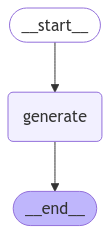

In [16]:
## 그래프 시각화

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
## 기본 Agent가 생성되었다. 이제 이걸 호출 해보자.
#  - 1) LLM에서 했던 것 처럼 invoke를 해주면 된다. generate라는 노드가 state를 인자로 받기에 이를 넣어주면 된다.
#  - 2) 기본 state를 만들어줘야 한다. : 사용자가 질문을 하니까 사용자가 질문을 하면 그 질문을 넣어주면 된다.
#  - 3) 사용자의 query를 넣어 준 다음에 그래프 invoke를 해주면 langgraph를 통해서 LLM의 응답을 받을 수 있다.

from langchain_core.messages import HumanMessage

initioal_state = {'messages': [HumanMessage(query)]}

graph.invoke(initioal_state)



{'messages': [AIMessage(content='인프런은 IT, 프로그래밍, 디자인, 마케팅, 비즈니스 등 다양한 분야의 온라인 강의를 제공하는 플랫폼입니다. \n\n**주요 분야별 강의 예시:**\n\n* **프로그래밍:**\n    * **웹 개발:** HTML, CSS, JavaScript, React, Vue.js, Angular, Node.js, Spring, Django, Ruby on Rails 등\n    * **앱 개발:** Android, iOS, Flutter, React Native 등\n    * **데이터 분석/과학:** Python, R, SQL, 머신러닝, 딥러닝, 데이터 시각화 등\n    * **게임 개발:** Unity, Unreal Engine 등\n    * **알고리즘/자료구조:** 코딩 테스트 준비, 알고리즘 기초/심화 학습\n    * **프로그래밍 언어:** Java, C++, C#, Go, Kotlin, Swift 등\n* **데이터베이스:**\n    * **SQL:** 기초, 심화, 튜닝\n    * **NoSQL:** MongoDB, Redis\n    * **데이터 모델링**\n* **클라우드:**\n    * **AWS, GCP, Azure:** 클라우드 기초, 서버리스, 인프라 구축\n    * **Docker, Kubernetes:** 컨테이너 기술\n* **보안:**\n    * **정보보안:** 네트워크 보안, 웹 보안, 시스템 보안\n    * **해킹/보안 분석**\n* **디자인:**\n    * **UI/UX 디자인:** Figma, Adobe XD\n    * **그래픽 디자인:** Photoshop, Illustrator\n    * **웹 디자인:** 반응형 웹 디자인\n* **마케팅:**\n    * **디지털 마케팅:** SEO, 콘텐츠 마케팅, 소셜 미디어 마케팅\n    * **데이터 기반 마케팅**\n* **비즈니스:**\n    * **기획/전략:** 사업 기획, 